<a href="https://colab.research.google.com/github/JohnNun/pneumonia_identification_project/blob/main/pneumonia_identification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Identification Project

# Business and Data Understanding


# Data preparation

In [ ]:
# For Google Colab only
!pip install keras
!pip install keras_preprocessing
!pip install tensorflow
!pip install scikeras[tensorflow]

In [2]:
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
import numpy as np
import os

In [3]:
# Following code taken from stackoverflow user fdsig
import json
import os
from pathlib import Path

# your api key
api_key = {
'username':"" ,
'key':""}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [ ]:
# Downloading and Importing images
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia

In [5]:
# Linking directory path
train_data_dir = 'chest_xray/train'
val_data_dir = 'chest_xray/val'

In [6]:
# Getting train and validation data from directory
test_generator = ImageDataGenerator().flow_from_directory(val_data_dir, target_size=(150,150), batch_size=16, seed=42)
train_generator = ImageDataGenerator().flow_from_directory(train_data_dir, target_size=(150,150), batch_size=652, seed=42)

Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [7]:
# Creating datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

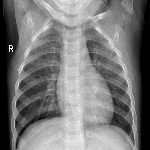

In [8]:
array_to_img(train_images[10])

In [9]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(652, 150, 150, 3)
(652, 2)
(16, 150, 150, 3)
(16, 2)


In [10]:
# Reshaping data
train_img_unrow = train_images.reshape(652, -1)
test_img_unrow = test_images.reshape(16, -1)

In [11]:
# Normalizing data
train_img_final = train_img_unrow/255
test_img_final = test_img_unrow/255

# Modeling

In [12]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

In [13]:
model_1 = Sequential()

In [14]:
model_1.add(layers.Input(shape=(67500,)))
model_1.add(Dense(50, activation='relu'))
model_1.add(Dense(25, activation='relu'))
model_1.add(Dense(10, activation='relu'))
model_1.add(Dense(2, activation='softmax'))

In [15]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model_1.fit(train_img_final, train_labels, epochs=10, batch_size=20, validation_data=(test_img_final, test_labels))

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.6809 - loss: 2.4516 - val_accuracy: 0.7500 - val_loss: 0.5200
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8507 - loss: 0.3029 - val_accuracy: 0.7500 - val_loss: 0.5488
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8882 - loss: 0.2359 - val_accuracy: 0.8750 - val_loss: 0.4231
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9147 - loss: 0.2066 - val_accuracy: 0.6250 - val_loss: 0.7142
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9312 - loss: 0.1716 - val_accuracy: 0.8750 - val_loss: 0.3754
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9447 - loss: 0.1508 - val_accuracy: 0.9375 - val_loss: 0.2823
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9536 - loss: 0.1102 - val_accuracy: 0.9375 - val_loss: 0.1995
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9422 - loss: 0.1454 - val_accuracy: 0.6250 - val_loss

In [17]:
model_2 = Sequential()

In [18]:
model_2.add(layers.Input(shape=(67500,)))
model_2.add(Dense(50, activation='relu', kernel_regularizer=l2(l2=0.05)))
model_2.add(Dense(25, activation='relu'))
model_2.add(Dense(10, activation='relu'))
model_2.add(Dense(2, activation='softmax'))

In [19]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model_2.fit(train_img_final, train_labels, epochs=50, batch_size=100, validation_data=(test_img_final, test_labels))

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 386ms/step - accuracy: 0.3412 - loss: 10.6668 - val_accuracy: 0.5000 - val_loss: 5.3442
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7410 - loss: 5.1438 - val_accuracy: 0.5000 - val_loss: 5.6650
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7352 - loss: 5.4904 - val_accuracy: 0.5625 - val_loss: 5.6321
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7280 - loss: 5.3558 - val_accuracy: 0.7500 - val_loss: 5.0627
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8151 - loss: 4.7899 - val_accuracy: 0.5625 - val_loss: 4.8728
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8432 - loss: 4.2062 - val_accuracy: 0.5625 - val_loss: 4.6702
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8531 - loss: 3.6060 - val_accuracy: 0.8125 - val_loss: 3.3581
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8692 - loss: 3.1234 - val_accuracy: 0.5625 - val_loss: 3.557

In [21]:
model_3 = Sequential()

In [22]:
model_3.add(layers.Input(shape=(67500,)))
model_3.add(Dense(100, activation='relu', kernel_regularizer=l2(l2=0.05)))
model_3.add(Dense(50, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(25, activation='relu'))
model_3.add(Dense(10, activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(2, activation='softmax'))

In [23]:
model_3.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [25]:
model_3.fit(train_img_final, train_labels, epochs=100, batch_size=300, validation_data=(test_img_final, test_labels), callbacks=[early_stop])

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3129 - loss: 10.9525 - val_accuracy: 0.5000 - val_loss: 10.6809
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6229 - loss: 10.5960 - val_accuracy: 0.5000 - val_loss: 10.6356
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6034 - loss: 10.5397 - val_accuracy: 0.5000 - val_loss: 10.5350
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6342 - loss: 10.4603 - val_accuracy: 0.5000 - val_loss: 10.5096
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6303 - loss: 10.4151 - val_accuracy: 0.5000 - val_loss: 10.4416
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6615 - loss: 10.3072 - val_accuracy: 0.5000 - val_loss: 10.4119
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6452 - loss: 10.3054 - val_accuracy: 0.5000 - val_loss: 10.3322
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6561 - loss: 10.2115 - val_accuracy: 0.500

In [31]:
model_4 = Sequential()

In [32]:
model_4.add(layers.Input(shape=(67500,)))
model_4.add(Dense(100, activation='relu', kernel_regularizer=l2(l2=0.1)))
model_4.add(Dense(50, activation='relu'))
model_4.add(Dense(25, activation='relu'))
model_4.add(Dense(10, activation='relu'))
model_4.add(Dense(2, activation='softmax'))

In [33]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
history = model_4.fit(train_img_final, train_labels, epochs=100, batch_size=300, validation_data=(test_img_final, test_labels), callbacks=[early_stop])

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 891ms/step - accuracy: 0.5586 - loss: 22.6559 - val_accuracy: 0.5000 - val_loss: 21.7648
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.7058 - loss: 16.9701 - val_accuracy: 0.5000 - val_loss: 11.8391
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7216 - loss: 11.2134 - val_accuracy: 0.5000 - val_loss: 10.2273
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.4233 - loss: 10.2074 - val_accuracy: 0.5000 - val_loss: 8.8697
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7178 - loss: 8.5269 - val_accuracy: 0.5000 - val_loss: 8.3299
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.4546 - loss: 8.2401 - val_accuracy: 0.5000 - val_loss: 7.6601
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6649 - loss: 7.2083 - val_accuracy: 0.5000 - val_loss: 7.1686
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7182 - loss: 6.4823 - val_accuracy: 0.5000 - v

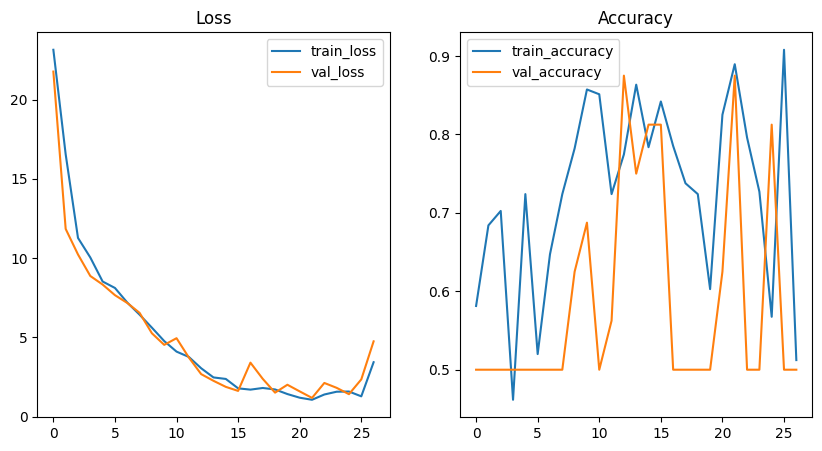

In [35]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=history.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=history.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=history.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=history.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();


# Evaluation